3D pose 예측 모델 사용법 및 코드
-------------
모델을 불러오고 저장된 이미지를 불러오는 커스텀 데이터셋을 정의하고 출력된 포즈를 시각화하는 과정 코드

### 모듈 불러오기 및 데이터셋 정의

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, Subset, IterableDataset
import torch.utils.data.distributed
import torchvision.transforms as transforms
from tqdm import tqdm
import cv2
import pickle
import glob
import os
import matplotlib.pyplot as plt

import _init_paths
from core.config import config
from core.config import update_config
import models
from utils.transforms import get_affine_transform, get_scale

dir_path = os.path.dirname(os.getcwd())
# config 파일 설정을 불러오기 위한 함수
update_config(dir_path + r"/config/cam4_posenet.yaml")
# 사용할 사전 학습된 모델 경로
test_file = dir_path + r"/../models/cam5_posenet.pth.tar"
# 사용할 데이터셋
data_path = "data_0705"

gpus = [0]

normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# cv2.VideoCapture 데이터셋
class POCdatasetCV2(IterableDataset):
    def __init__(self, cfg, transform=None, start_idx=0, end_idx=None):
        self.dir_path = os.path.dirname(os.getcwd()) + "/" + data_path
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.cam_list = [1,2,3,4]
        self.camera = self.get_cam()
        self.caps = self.get_caps()

        self.transform = transform
        self.image_size = np.array(cfg.NETWORK.IMAGE_SIZE)
        
        if  self.end_idx is None:
            self.end_idx = int(self.caps[0].get(cv2.CAP_PROP_FRAME_COUNT))

    def get_caps(self):
        caps = []
        video_path = self.dir_path + "/hdVideos/"
        for i in self.cam_list:
            cap = cv2.VideoCapture(video_path + f"hd_00_{i:02d}.mp4")
            cap.set(cv2.CAP_PROP_POS_FRAMES, self.start_idx)
            caps.append(cap)
            
        return caps
        
    def get_cam(self):
        camera = []
        # for i in range(1,5):
        for i in self.cam_list:
            meta_file = self.dir_path + "/calibration/camera" + str(i) + ".pkl"
            with open(meta_file, "rb") as f:
                calib = pickle.load(f)
                
            M = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, -1.0], [0.0, 1.0, 0.0]])
            R, _ = cv2.Rodrigues(calib['rvec'])
            # R = R.dot(M)
            T = (
                -np.dot(R.T, calib['tvec']) * 1000
            )

            # m 딕셔너리 생성
            cam = {
                'R': R,
                'T': T,  
                'fx': calib['camera_matrix'][0, 0],
                'fy': calib['camera_matrix'][1, 1],
                'cx': calib['camera_matrix'][0, 2],
                'cy': calib['camera_matrix'][1, 2],
                'k': calib['dist_coeffs'][0][[0,1,4]].reshape(3, 1),  # 왜곡 계수 k1, k2, k3
                'p': calib['dist_coeffs'][0][[2,3]].reshape(2, 1)  # 왜곡 계수 p1, p2
            }
            camera.append(cam)
        return camera
    
    def __iter__(self):
        idx = 0     
        while True:
            if idx >= self.end_idx - self.start_idx:
                break
            idx += 1
            
            inputs = []
            for cap in self.caps:
                ret, data_numpy = cap.read()
                if not ret:
                    print(f"Failed to read image")
                    assert False
                
                data_numpy = cv2.cvtColor(data_numpy, cv2.COLOR_BGR2RGB)     

                height, width, _ = data_numpy.shape
                c = np.array([width / 2.0, height / 2.0])
                s = get_scale((width, height), self.image_size)
                r = 0

                trans = get_affine_transform(c, s, r, self.image_size)
                input = cv2.warpAffine(
                    data_numpy,
                    trans, (int(self.image_size[0]), int(self.image_size[1])),
                    flags=cv2.INTER_LINEAR)
                input = self.transform(input)

                inputs.append(input)

            meta = []

            for i in range(len(self.cam_list)):
                # m 딕셔너리 생성
                m = {
                'center': c,
                'scale': s,
                'rotation': r,
                'camera': self.camera[i]
                }
                meta.append(m)
                
            yield inputs, meta
        for cap in self.caps:
            cap.release()

/home/dojan/anaconda3/envs/selfpose3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 모델 불러오기

In [6]:
# 모델 불러오기

test_file = r"/home/dojan/FOCUS-1/SelfPose3d/models/POC_posenet.pth.tar"
model = models.multi_person_posenet_ssv.get_multi_person_pose_net(
        config, is_train=True)
with torch.no_grad():
    model = torch.nn.DataParallel(model, device_ids=gpus).cuda()
model.module.load_state_dict(torch.load(test_file), strict=False)

<All keys matched successfully>

In [7]:
type(model)

torch.nn.parallel.data_parallel.DataParallel

### evaluate

In [4]:
start_idx = 0   # 시작 프레임 인덱스
end_idx = None  # 끝 프레임 인덱스, None일 경우 마지막까지

test_dataset_cv2 = POCdatasetCV2(
    config, transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]),
    start_idx=start_idx, 
    end_idx=end_idx)

test_loader_cv2 = DataLoader(
        test_dataset_cv2,
        batch_size=1,
        shuffle=False)

model.eval()
preds, roots = [], []
feature_spaces = []
with torch.no_grad():
    for inputs, meta in tqdm(test_loader_cv2):
        pred, heatmaps, grid_centers, root_cubes = model(views1=inputs, meta1=meta, inference=True)

        pred = pred.detach().cpu().numpy()
        root = grid_centers.detach().cpu().numpy()
        root_cubes = root_cubes.detach().cpu().numpy()
        for b in range(pred.shape[0]):
            preds.append(pred[b])
            roots.append(root[b])
            feature_spaces.append(root_cubes[b])

0it [00:00, ?it/s]/home/dojan/anaconda3/envs/selfpose3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
8812it [13:50, 10.61it/s]


### 시각화 (한 프레임)

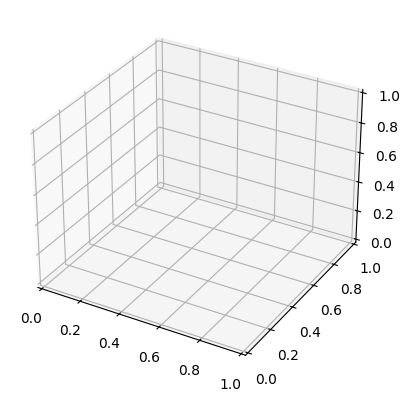

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

LIMBS = [
    [0, 1],
    [0, 2],
    [0, 3],
    [3, 4],
    [4, 5],
    [0, 9],
    [9, 10],
    [10, 11],
    [2, 6],
    [2, 12],
    [6, 7],
    [7, 8],
    [12, 13],
    [13, 14],
]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

preds = output['preds'][218]

for pose in preds:
    if pose[2][3] == -1:
        continue

    x = pose[:, 0]
    y = pose[:, 1]
    z = pose[:, 2]

    # 3D 플롯 생성


    ax.scatter(x, y, z, c='r', marker='o')

    for limb in LIMBS:
        joint1, joint2 = limb
        x_values = [pose[joint1][0], pose[joint2][0]]
        y_values = [pose[joint1][1], pose[joint2][1]]
        z_values = [pose[joint1][2], pose[joint2][2]]
        ax.plot(x_values, y_values, z_values, 'ro-')

    # Annotate the joints
    for idx, coord in enumerate(pose):
        ax.text(coord[0], coord[1], coord[2], idx, fontsize=12, ha='right')


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


plt.show()

### 시각화 (영상화)

Animation saved as ../temp/sample.avi


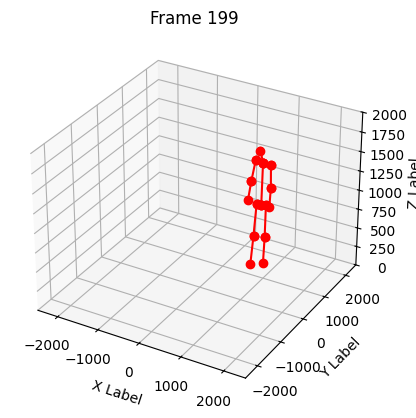

In [49]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import imageio
import math

LIMBS = [
    [0, 1],
    [0, 2],
    [0, 3],
    [3, 4],
    [4, 5],
    [0, 9],
    [9, 10],
    [10, 11],
    [2, 6],
    [2, 12],
    [6, 7],
    [7, 8],
    [12, 13],
    [13, 14],
]

def calculate_angle(p1, p2, p3):
    vector1 = p1 - p2
    vector2 = p3 - p2
    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    angle = math.degrees(math.acos(dot_product / (magnitude1 * magnitude2)))
    return angle

def normal_pose(pose):
    if pose[2][3] == -1:
        return 0
    if min(pose[8][2], pose[14][2]) < 0 or min(pose[8][2], pose[14][2]) > 150:
        return 0
    '''
    코, 목, 골반을 잇는 관절을 기준으로 팔꿈치, 무릎 관절들이 안/밖으로 튀어나가는지 확인
    '''
    ref_vector = np.cross(pose[2][:3] - pose[0][:3], pose[1][:3] - pose[0][:3])
    ankle_vectors = []
    ankle_vectors.append(np.cross(pose[5][:3] - pose[4][:3], pose[3][:3] - pose[4][:3]))
    ankle_vectors.append(np.cross(pose[11][:3] - pose[10][:3], pose[9][:3] - pose[10][:3]))
    ankle_vectors.append(np.cross(pose[6][:3] - pose[7][:3], pose[8][:3] - pose[7][:3]))
    ankle_vectors.append(np.cross(pose[12][:3] - pose[13][:3], pose[14][:3] - pose[13][:3]))
    
    for ankle_vector in ankle_vectors:
        ref_vector_norm = np.linalg.norm(ref_vector)
        ankle_vector_norm = np.linalg.norm(ankle_vector)
        angle = math.degrees(math.acos(np.dot(ref_vector, ankle_vector) / (ref_vector_norm * ankle_vector_norm)))
        if angle > 90:
            return 0
    '''
    팔, 다리 길이 비율 확인(미완성)
    '''
    return 1

def update_plot(frame_num, ax, fig, pred):
    ax.clear()
    for pose in pred:
        # if normal_pose(pose)==False:
        #     continue
        if pose[2][3] == -1:
            continue
        if min(pose[8][2], pose[14][2]) < 0 or min(pose[8][2], pose[14][2]) > 150:
            continue

        x = pose[:, 0]
        y = pose[:, 1]
        z = pose[:, 2]

        ax.scatter(x, y, z, c='r', marker='o')

        for limb in LIMBS:
            joint1, joint2 = limb
            x_values = [pose[joint1][0], pose[joint2][0]]
            y_values = [pose[joint1][1], pose[joint2][1]]
            z_values = [pose[joint1][2], pose[joint2][2]]
            ax.plot(x_values, y_values, z_values, 'ro-')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title(f'Frame {frame_num}')
    ax.set_xlim(-2500, 2500)  # x축 범위 설정
    ax.set_ylim(-2500, 2500)  # y축 범위 설정
    ax.set_zlim(0, 2000)  # z축 범위 설정

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


outfile = '../temp/sample.avi'
writer = imageio.get_writer(outfile, fps=15)

for i, pred in enumerate(preds):
    update_plot(i, ax, fig, pred)
    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    writer.append_data(frame)

writer.close()

print(f'Animation saved as {outfile}')


### 출력
포즈 예측 결과를 피클 파일로 출력

In [1]:
import pickle
with open("../output.pkl", "rb") as f:
    output = pickle.load(f)

In [12]:
import pickle

with open("/home/zzol/SelfPose3d/result_1.pkl", "rb") as f:
    result = pickle.load(f)

In [25]:
result[1000][3].keys()

dict_keys(['age', 'gender', 'preds_3d', 'roots_3d'])

### 부록1
실시간 카메라 입력과 모델 예측 시각화 출력을 위한 데이터셋 정의

In [4]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, IterableDataset
import torch.utils.data.distributed
import torchvision.transforms as transforms
from tqdm import tqdm
import cv2
import pickle
import glob
import os

import _init_paths
from core.config import config
from core.config import update_config
import dataset
import models
from utils.transforms import get_affine_transform, get_scale

# config 파일 설정을 불러오기 위한 함수
update_config(r"/home/zzol/SelfPose3d/aisl/config/cam4_posenet.yaml")
# 사용할 사전 학습된 모델 경로
test_file = r"/home/zzol/SelfPose3d/models/cam5_posenet.pth.tar"

# 사용할 GPU 번호
gpus = [0]

normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

# 실시간 데이터셋 클래스 정의 (IterableDataset 상속)
class RT_POCdataset(IterableDataset):
    def __init__(self, cfg, transform=None):
        # usb 카메라 source 번호 (직접 찾거나 확인 필요)
        self.video_source = [4, 12, 22, 26]
        # 입력 이미지 전처리 torchvision 함수
        self.transform = transform
        self.image_size = np.array(cfg.NETWORK.IMAGE_SIZE)
        # 카메라 정보
        self.camera = self.get_camera()

    def get_cap(self, source):
        print(f'source: {source}')
        cap = cv2.VideoCapture(source)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
        cap.set(cv2.CAP_PROP_FPS, 15)
        return cap

    def get_camera(self):
        camera = []
        for i in range(1, 5):
            meta_file = rf"/home/zzol/SelfPose3d/aisl/data_0715/calibration/camera{i}.pkl"
            with open(meta_file, "rb") as f:
                calib = pickle.load(f)
            
            R, _ = cv2.Rodrigues(calib['rvec'])
            T = (
                -np.dot(R.T, calib['tvec']) * 1000 # mm 단위로 변환
            )

            # m 딕셔너리 생성
            cam = {
                'R': R,
                'T': T,
                'fx': calib['camera_matrix'][0, 0],
                'fy': calib['camera_matrix'][1, 1],
                'cx': calib['camera_matrix'][0, 2],
                'cy': calib['camera_matrix'][1, 2],
                'k': calib['dist_coeffs'][0][[0,1,4]].reshape(3, 1),  # 왜곡 계수 k1, k2, k3
                'p': calib['dist_coeffs'][0][[2,3]].reshape(2, 1)  # 왜곡 계수 p1, p2
            }
            camera.append(cam)
        return camera

    def get_meta(self, c, s, r):
        meta = []
        for i in range(4):
            # m 딕셔너리 생성
            m = {
            'center': c,
            'scale': s,
            'rotation': r,
            'camera': self.camera[i]
            }
            meta.append(m)
        return meta

    def __iter__(self):
        caps = [self.get_cap(source) for source in self.video_source]
        for i, cap in enumerate(caps):
            if not cap.isOpened():
                raise RuntimeError(f"Failed to open camera {self.video_source[i]}")
            
        while True:
            frames = []
            for i, cap in enumerate(caps):
                ret, frame = cap.read()
                if not ret:
                    print(f'failed to read frame: {i}')
                    break
                frames.append(frame)

            if len(frames) != len(caps):
                print(f'frame length: {len(frames)}')
                print(f'cap length: {len(caps)}')
                print("모든 카메라로부터 프레임을 읽지 못했습니다.")
                break
            
            inputs = []
            for data_numpy in frames:                        
                data_numpy = cv2.cvtColor(data_numpy, cv2.COLOR_BGR2RGB)     

                height, width, _ = data_numpy.shape
                c = np.array([width / 2.0, height / 2.0])
                s = get_scale((width, height), self.image_size)
                r = 0

                trans = get_affine_transform(c, s, r, self.image_size)
                input = cv2.warpAffine(
                    data_numpy,
                    trans, (int(self.image_size[0]), int(self.image_size[1])),
                    flags=cv2.INTER_LINEAR)
                input = self.transform(input)

                inputs.append(input)
            
            meta = self.get_meta(c, s, r)

            yield inputs, meta

        for cap in caps:
            cap.release()

test_dataset = RT_POCdataset(
        config, transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]))

test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import imageio

model.eval()
with torch.no_grad():
    for inputs, meta in test_loader:
        pred, heatmaps, grid_centers = model(views1=inputs, meta1=meta, inference=True)
        heatmap = heatmaps[0].squeeze(0).cpu().numpy()
        cv2.imshow("RT_heatmap", heatmap[2])
        cv2.waitKey(1)
        # pred = pred[0].detach().cpu().numpy()

In [1]:
# MultiPersonPoseNetSSV
def forward(
    self,
    views1=None,
    meta1=None,
    inference=True,
    epoch=0,
):
    if inference:
        return self.do_inference(views=views1, meta=meta1, input_heatmaps=None, visualize_attn=False)

def do_inference(self, views=None, meta=None, input_heatmaps=None, visualize_attn=False):
    if views is not None:
        all_heatmaps = []
        for view in views:
            heatmaps = self.backbone(view)
            all_heatmaps.append(heatmaps)

    device = all_heatmaps[0].device
    batch_size = all_heatmaps[0].shape[0]

    _, _, _, grid_centers = self.root_net(all_heatmaps, meta)
    print("rootnet finished")

    pred = torch.zeros(batch_size, self.num_cand, self.num_joints, 5, device=device)
    pred[:, :, :, 3:] = grid_centers[:, :, 3:].reshape(batch_size, -1, 1, 2)

    if not self.train_only_rootnet:
        if not self.train_only_2d:
            for n in range(self.num_cand):
                index = pred[:, n, 0, 3] >= 0
                if torch.sum(index) > 0:
                    single_pose = self.pose_net(all_heatmaps, meta, grid_centers[:, n])
                    pred[:, n, :, 0:3] = single_pose.detach()
                    del single_pose
    print("posenet finished")

    return pred, all_heatmaps, grid_centers


meta = {
            'image': image_file,
            'num_person': nposes,
            'joints_3d': joints_3d_u,
            'joints_3d_vis': joints_3d_vis_u,
            'roots_3d': roots_3d,
            'joints': joints_u,
            'joints_vis': joints_vis_u,
            O 'center': c,
            O 'scale': s,
            O 'rotation': r,
            O 'camera': db_rec['camera']
        }


SyntaxError: invalid syntax (2115795192.py, line 49)

### 부록2
모델의 연산과정 코드

rootnet (cuboid_proposal_net_soft)

In [ ]:
# rootnet
def forward(self, all_heatmaps, meta, flip_xcoords=None):
    if self.rootnet_train_synth:
        root_cubes_main, grid_centers = self.get_grid_centres(all_heatmaps, meta, flip_xcoords)
        return root_cubes_main, None, None, grid_centers
    
def get_grid_centres(self, all_heatmaps, meta, flip_xcoords):
    # with torch.no_grad():
    # self.v2v_net.eval()
    all_heatmaps_copy = [a[:, self.root_id, :, :][:, None].clone() for a in all_heatmaps]

    initial_cubes, grids = self.project_layer(
        all_heatmaps_copy,
        meta,
        self.grid_size,
        [self.grid_center],
        self.cube_size,
        flip_xcoords=flip_xcoords,
    )
    root_cubes = self.v2v_net(initial_cubes)
    root_cubes = root_cubes.squeeze(1)
    grid_centers = self.proposal_layer(root_cubes, meta, grids)

    return root_cubes, grid_centers

# project_layer
def forward(self, heatmaps, meta, grid_size, grid_center, cube_size, flip_xcoords=None):
    cubes, grids = self.get_voxel(heatmaps, meta, grid_size, grid_center, cube_size, flip_xcoords=flip_xcoords)
    return cubes, grids

In [ ]:
def get_voxel(self, heatmaps, meta, grid_size, grid_center, cube_size, flip_xcoords=None):
    device = heatmaps[0].device
    batch_size = heatmaps[0].shape[0]
    num_joints = heatmaps[0].shape[1]
    nbins = cube_size[0] * cube_size[1] * cube_size[2] # = 8000 * 8000 * 2000
    n = len(heatmaps)
    cubes = torch.zeros(batch_size, num_joints, 1, nbins, n, device=device) # (1, 15, 1, 8000*8000*2000, 4)
    # h, w = heatmaps[0].shape[2], heatmaps[0].shape[3]
    w, h = self.heatmap_size
    grids = torch.zeros(batch_size, nbins, 3, device=device) # (1, 8000*8000*2000, 3)
    bounding = torch.zeros(batch_size, 1, 1, nbins, n, device=device) # (batch_size, 1, 1, 8000*8000*2000, 4)
    for i in range(batch_size):
        if len(grid_center[0]) == 3 or grid_center[i][3] >= 0:
            # This part of the code can be optimized because the projection operation is time-consuming.
            # If the camera locations always keep the same, the grids and sample_grids are repeated across frames
            # and can be computed only one time.
            # 그리드 격자 생성
            if len(grid_center) == 1:
                grid = self.compute_grid(grid_size, grid_center[0], cube_size, device=device)
            else:
                grid = self.compute_grid(grid_size, grid_center[i], cube_size, device=device)
            grids[i:i + 1] = grid
            # grid = (-4000 -3500 -200) ~ (4000 4500 1800)
            for c in range(n):
                center = meta[c]['center'][i]
                scale = meta[c]['scale'][i]
                rotation = meta[c]['rotation'][i]

                width, height = center * 2
                trans = torch.as_tensor(
                    get_transform(center, scale, rotation, self.img_size),
                    dtype=torch.float,
                    device=device)
                cam = {}
                for k, v in meta[c]['camera'].items():
                    cam[k] = v[i]
                # 월드 좌표를 카메라 좌표로 변환 (캘리브레이션)
                xy = cameras.project_pose(grid, cam)

                bounding[i, 0, 0, :, c] = (xy[:, 0] >= 0) & (xy[:, 1] >= 0) & (xy[:, 0] < width) & (
                            xy[:, 1] < height)
                xy = torch.clamp(xy, -1.0, max(width, height))
                xy = do_transform(xy, trans)
                if flip_xcoords is not None and flip_xcoords[i]:
                    xy[..., 0] = self.img_size[0] - xy[..., 0]
                xy = xy * torch.tensor(
                    [w, h], dtype=torch.float, device=device) / torch.tensor(
                    self.img_size, dtype=torch.float, device=device)
                sample_grid = xy / torch.tensor(
                    [w - 1, h - 1], dtype=torch.float,
                    device=device) * 2.0 - 1.0
                sample_grid = torch.clamp(sample_grid.view(1, 1, nbins, 2), -1.1, 1.1)

                # if pytorch version < 1.3.0, align_corners=True should be omitted.
                cubes[i:i + 1, :, :, :, c] += F.grid_sample(heatmaps[c][i:i + 1, :, :, :], sample_grid, align_corners=True)

    # cubes = cubes.mean(dim=-1)
    cubes = torch.sum(torch.mul(cubes, bounding), dim=-1) / (torch.sum(bounding, dim=-1) + 1e-6)
    cubes = cubes.clone()
    cubes[cubes != cubes] = 0.0
    cubes = cubes.clamp(0.0, 1.0)

    cubes = cubes.view(batch_size, num_joints, cube_size[0], cube_size[1], cube_size[2])  ##
    return cubes, grids


In [ ]:
# proposal_layer
def forward(self, root_cubes, meta, grids):
    batch_size = root_cubes.shape[0]

    topk_values, topk_unravel_index = nms(root_cubes.detach(), self.num_cand)
    topk_unravel_index = self.get_real_loc(topk_unravel_index)

    grid_centers = torch.zeros(batch_size, self.num_cand, 5, device=root_cubes.device)
    grid_centers[:, :, 0:3] = topk_unravel_index
    grid_centers[:, :, 4] = topk_values

    grid_centers[:, :, 3] = (
        topk_values > self.threshold
    ).float() - 1.0  # if ground-truths are not available.

    return grid_centers

posenet (PoseRegressionNet)

In [ ]:
# posenet
def forward(self, all_heatmaps, meta, grid_centers, flip_xcoords=None):
    batch_size = all_heatmaps[0].shape[0]
    num_joints = all_heatmaps[0].shape[1]
    device = all_heatmaps[0].device
    pred = torch.zeros(batch_size, num_joints, 3, device=device)
    cubes, grids = self.project_layer(all_heatmaps, meta,
                                        self.grid_size, grid_centers, self.cube_size, flip_xcoords=flip_xcoords)

    index = grid_centers[:, 3] >= 0
    valid_cubes = self.v2v_net(cubes[index])
    pred[index] = self.soft_argmax_layer(valid_cubes, grids[index])

    return pred

# 연습장

In [3]:
data_iter = iter(test_loader)
inputs, meta = next(data_iter)

In [4]:
inputs[0].shape

torch.Size([4, 3, 512, 960])

In [5]:
all_heatmaps = []
for view in inputs:
    view = view.cuda()
    heatmaps = model.module.backbone(view)
    all_heatmaps.append(heatmaps)


In [6]:
all_heatmaps[0].shape

torch.Size([4, 15, 128, 240])

In [28]:
di, dm = test_dataset[0]
print(len(di))

4


In [36]:
di[0].shape

torch.Size([3, 512, 960])

In [9]:
roots[160]

array([[-5.0633057e+01,  1.8797471e+03,  8.5263159e+02,  0.0000000e+00,
         5.4371047e-01],
       [ 4.5569629e+02,  1.3734180e+03,  7.4736841e+02, -1.0000000e+00,
         1.5906982e-01],
       [ 1.0632910e+03,  6.6455713e+02,  7.4736841e+02, -1.0000000e+00,
         5.0562765e-02],
       [ 1.0632910e+03,  9.6835400e+02,  8.5263159e+02, -1.0000000e+00,
         4.0693417e-02],
       [ 8.6075928e+02,  6.6455713e+02,  7.4736841e+02, -1.0000000e+00,
         4.0572539e-02],
       [ 8.6075928e+02,  9.6835400e+02,  1.0631577e+03, -1.0000000e+00,
         2.8884413e-02],
       [ 8.6075928e+02,  3.6075928e+02,  1.0631577e+03, -1.0000000e+00,
         2.6954655e-02],
       [ 8.6075928e+02,  5.6329102e+02,  1.0631577e+03, -1.0000000e+00,
         2.6828468e-02],
       [ 5.5696191e+02,  3.6075928e+02,  9.5789478e+02, -1.0000000e+00,
         1.9179787e-02],
       [ 8.6075928e+02,  1.5822803e+02,  1.2736841e+03, -1.0000000e+00,
         1.3165885e-02]], dtype=float32)